In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

In [2]:
spark = SparkSession.builder.appName("WaterPotabilityPrediction").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 07:48:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data = spark.read.csv("Water1.csv", header=True, inferSchema=True)
data.describe().show()
print(data.columns)

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|                ph|          Hardness|           Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|         Potability|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|              2248|              2293|             2293|              2293|              2293|              2293|              2293|              2293|              2293|               2293|
|   mean| 7.087046467930066|196.39033467318723|22074.33533378741|  7.13298722773223|333.39334730577684|425.45570192935264|14.229174077558303| 66.49951785248768|3.9671531697581806|0.39031836022677713|


In [4]:
print("row count:", data.count())
print("rowname:")
data.printSchema()
data.show(5)

row count: 2293
rowname:
root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)

+-----------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|          Sulfate|     Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+----------+
|7.08079450427

In [5]:
data.summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|         Potability|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|              2248|              2293|              2293|              2293|              2293|              2293|              2293|              2293|              2293|               2293|
|   mean| 7.087046467930066|196.39033467318723| 22074.33533378741|  7.13298722773223|333.39334730577684|425.45570192935264|14.229174077558303| 66.49951785248768|3.9671531697581806|0.39031836022677

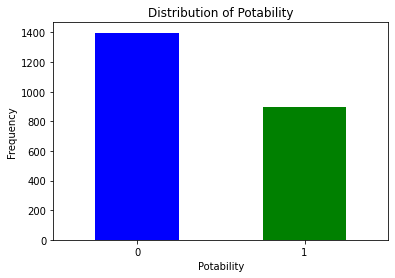

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


potability_pdf = data.select("Potability").toPandas()
potability_pdf['Potability'].value_counts().plot(kind='bar', color=['blue', 'green'])


plt.title('Distribution of Potability')
plt.xlabel('Potability')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.show()

In [9]:
from pyspark.sql.functions import col, count, when, lit

# Count the number of missing values
missing_values = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])

missing_values.show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| 45|       0|     0|          0|      0|           0|             0|              0|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



In [10]:
total_rows = data.count()
missing_percentage = data.select(
    [(count(when(col(c).isNull(), c)) / lit(total_rows) * 100).alias(c + "_missing_pct") 
     for c in data.columns]
)
missing_percentage.show()

+-----------------+--------------------+------------------+-----------------------+-------------------+------------------------+--------------------------+---------------------------+---------------------+----------------------+
|   ph_missing_pct|Hardness_missing_pct|Solids_missing_pct|Chloramines_missing_pct|Sulfate_missing_pct|Conductivity_missing_pct|Organic_carbon_missing_pct|Trihalomethanes_missing_pct|Turbidity_missing_pct|Potability_missing_pct|
+-----------------+--------------------+------------------+-----------------------+-------------------+------------------------+--------------------------+---------------------------+---------------------+----------------------+
|1.962494548626254|                 0.0|               0.0|                    0.0|                0.0|                     0.0|                       0.0|                        0.0|                  0.0|                   0.0|
+-----------------+--------------------+------------------+-----------------------+-